## Исследование продаж компьтерных игр для интернет-магазина «Стримчик»

**Бизнес-задача от интернет-магазина компьютерных игр:** выявить закономерности, определяющие усешность компьютерной игры для планирования рекламных кампаний на основе исторических данных из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы. В исследовании использованы данные до 2016 года для рекламной кампании на 2017 год. 

Цель исследования - создать систему, подходящую для любого актуального временного диапазона.

Содержание:
1. [Получение данных и изучение общей информации.](##step1)  
2. [Подготовка данных.](##step2)
3. [Исследовательский анализ данных.](##step3)
4. [Портрет пользователя каждого региона.](##step4)
5. [Проверка гипотез.](##step5)
6. [Окончательные выводы.](##step6)


Имеющиеся данные:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (0-100)
- User_Score — оценка пользователей (0-10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## 1. Получение данных и изучение общей информации. <a id='#step1'></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import math as mt
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import norm
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('/datasets/games.csv')#, sep="\t")
display(df.head(3))
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вывод:

На входе имеем таблицу с 11 столбцами и 16715 строками. В последних трех столбцах очень много пропусков (более половины). Названия столбцов необходимо привести к единому типу, т.к. сейчас они в разном регистре. Также необходимо поменять типы данных в столбцах Year_of_Release  User_Score. Подготовим данные для дальнейшего анализа:

## 2. Подготовка данных. <a id='#step1'></a>

In [3]:
#Приведем названия столбцов к нижнему регистру
df.columns = map(str.lower, df.columns)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Сразу удалим из таблицы строки, где не указаны названия игр.

In [4]:
#удалим из таблицы строки, где нет названий
df['name'] = df['name'].fillna(0)
df = df.query('name != 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Заменим типы данных: 'year_of_release' приведем к целочисленному, а 'user_score' к float. Для этого напишем функции. Также сразу напишем функцию для заполнения пропусков:

In [5]:
#функция изменения типа
def change_type(col, new_type):
    df[col]= df[col].astype(new_type)
    
#функция заполнения пропусков
def fill(col1, val):
    df[col1] = df[col1].fillna(val)

#функция перевода строк в числа
def to_numb(col2):
    df[col2] = pd.to_numeric(df[col2], errors = 'coerce')

В столбце год релиза есть пропуски. Заполним их до изменения типа данных. Если изучить их внимательнее, то можно заметить, что наименование многих игр встречается несколько раз, и в некоторых одно из значений ненулевое. Также, можно заметить, что релиз был на разных платформах. Таким образом наиболее близко к реальности будет заменить пропуски в таких позициях на дату релиза единственным заполненным значением. Для этого проще всего сгруппировать игры по названию и заполнить минимальным значением в этой группе. Выполним это:

In [6]:
#заполним пропуски и проверим с помощью среднего значения по столбцу работу функции
print(df['year_of_release'].mean())
df['year_of_release'] = df['year_of_release'].fillna(df.groupby('name')['year_of_release'].transform('min'))
print(df['year_of_release'].mean())

fill('year_of_release', 0)
change_type('year_of_release', 'int')
print('----------------')

#проверим сколько осталось незаполненных строк
test = df.query('year_of_release == 0')
print('Строк с незаполненным годом выпуска:', len(test))

2006.4862563853078
2006.4885615983583
----------------
Строк с незаполненным годом выпуска: 146


Незаполненых строк осталось 146 шт. Удалим их.

In [7]:
df = df.query('year_of_release != 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
name               16567 non-null object
platform           16567 non-null object
year_of_release    16567 non-null int64
genre              16567 non-null object
na_sales           16567 non-null float64
eu_sales           16567 non-null float64
jp_sales           16567 non-null float64
other_sales        16567 non-null float64
critic_score       8075 non-null float64
user_score         9934 non-null object
rating             9868 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Построим тепловую карту, чтобы нaглядно оценить оставшиеся пропуски:

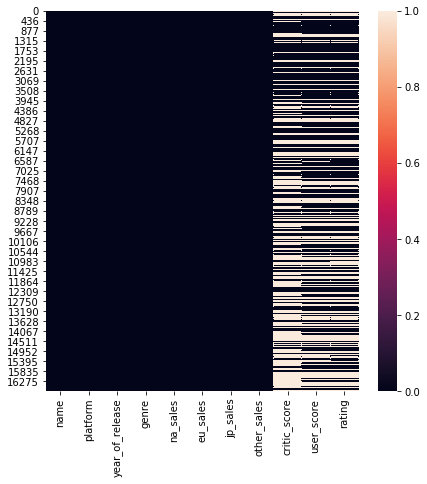

In [8]:
plt.figure(figsize=(7,7))
sns.heatmap(df.isnull()).set_title;

Пропуски остались в трех последних столбцах, проанализируем их.

Видим, что пропуски в последних трех столбцах коррелируют друг с другом, а больше всего их с столбце с оценками критиков. А из .info видно, что таких строк в таблице в столбеце "rating" более половины. Entertainment Software Rating Board (ESRB) — негосударственная организация, присваивающая категорию компьютерной игре, была основана в 1994 году. Возникает версия, что игры выпущенные до этого года не могли пройти сертификацию. Однако если игра существовала и после 1994 года, то могла быть сертифицирована и после выхода. 
Проверим ниже версию, что незаполненными в столбце 'rating' являются игры, выпущеные до 1994г.

In [9]:
#заполним пропуски значением 'unknown'
fill('rating', 'unknown')
unknown = df.query('rating == "unknown"')
print('Максимальный год выпуска игры без категории:',unknown['year_of_release'].max())
#df.info()

Максимальный год выпуска игры без категории: 2016


Версия не подтвердилась. Следовательно модифицировать таблицу по этому принципу не будем.

Проанализируем взаимосвязь категории с названием и платформой, на которой выпущена игра. Сгруппировав данные по платформам и проанализировав те, по которым отсутствует категория, получим следующий список с годами выпуска (информация из википедии и других интернет-ресурсов):

- Atari 2600 -прекращение официальной поддержки 1.01.1992г.
- 3DO Interactive Multiplayer - игровая приставка, выпускавшаяся до 1996г.
- DC - по сей день
- GB - по сей день
- GEN - по сей день
- GG - по сей день
- N64 - по сей день, приставка
- NES - приставка, выпуск до октября 2003 года. Окончание сервиса - 2007г.
- PCFX - по сей день
- SAT - по сей день
- SCD - по сей день
- SNES - по сей день.
- TG16 - по сей день.
- WS - по сей день

Итак, видим, что большинство платформ поддерживаются по сей день, при этом не имеют присвоенной возрастной категории. 

Возможно найдутся такие игры, где заполнено одно значение и не заполнены остальные. проверим эту версию и в случае удачи скопируем это значение на остальные платформы:

In [10]:
rat = df.groupby('platform')['rating'].count()
print(rat)
adf = (df.pivot_table(index=['name','platform','year_of_release','genre','rating' ],
                      values=['na_sales'], aggfunc=['sum']).reset_index())
adf.head(50)

platform
2600     117
3DO        3
3DS      515
DC        52
DS      2129
GB        97
GBA      813
GC       552
GEN       27
GG         1
N64      318
NES       98
NG        12
PC       970
PCFX       1
PS      1190
PS2     2140
PS3     1320
PS4      392
PSP     1203
PSV      429
SAT      173
SCD        6
SNES     239
TG16       2
WS         6
Wii     1301
WiiU     147
X360    1250
XB       817
XOne     247
Name: rating, dtype: int64


,name,platform,year_of_release,genre,rating,sum
,,,,,,na_sales
0,Beyblade Burst,3DS,2016,Role-Playing,unknown,0.00
1,Fire Emblem Fates,3DS,2015,Role-Playing,unknown,0.81
2,Frozen: Olaf's Quest,3DS,2013,Platform,unknown,0.27
3,Frozen: Olaf's Quest,DS,2013,Platform,unknown,0.21
4,Haikyu!! Cross Team Match!,3DS,2016,Adventure,unknown,0.00
5,Tales of Xillia 2,PS3,2012,Role-Playing,T,0.20
6,'98 Koshien,PS,1998,Sports,unknown,0.15
7,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,unknown,0.00
8,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,unknown,0.11


Версия не подтвердилась. Попробуем сгруппировать по жанру и посмотреть какие категории они содержат.

In [11]:
adf1 = df.pivot_table(index=['genre','rating' ],values=['na_sales'], aggfunc=['sum']).reset_index()
adf1.head(20)

,genre,rating,sum
,,,na_sales
0,Action,AO,1.26
1,Action,E,112.19
2,Action,E10+,120.09
3,Action,EC,0.42
4,Action,M,282.27
5,Action,T,161.80
6,Action,unknown,195.67
7,Adventure,E,33.89
8,Adventure,E10+,6.26


Видим, что заполнить категорию по принадлежности к жанру тоже не получится, поскльку в одном жанре выпускаются игры для разных возрастных категорий. 

Таким образом, приходим к выводу, что в столбце "rating" оставим пропуски заполненными на значение unknown, чтобы отличать их от корректных данных.

Заполнение пропусков "оценок критиков" и "оценок пользователей" с помощью классических методов, таких как среднее или медиана считаю нецелесообразным, тем более при таком их объеме, поскольку корреляция оценок и рейтинга с другими столбцами непредсказуема.  Ведь нельзя утверждать, что если, например, один фильм одного жанра набрал определенный рейтинг, то следовательно и другой фильм этого жанра будет с таким же рейтингом, ведь это как раз и есть уникальность фильма. Кроме того, если заполнить более 50% данных рассчетными величинами, а потом их же анализировать, то  какой смысл в таком анализе? Удалять такие строки тоже не нужно, поскольку в других столбцах содержится ценная информация. По этой причине столбцы "critic_score" и "user_score" заполним значениями, которые не могут встретиться в правильных данных, пусть это будет 5000, а при анализе данных с участием этих столбцов создадим отдельные таблицы, которые не будут содержать эти строки.
 
Также в столбце "user_score" есть значения tbd, что означает to be determinate, т.е. значния пока не определены. Отсортировав таблицу по этому значению и сгруппировав по году выпуска становится понятно, что это не связано с годом выпуска, поскольку в списке не только новые игры. Возможно, независимо от года выпуска, рейтинг пользователей не был присвоен также и потому, что игры напроитив очень старые, а возможность пользователей выставлять рейтинг онлайн появилась не так давно. В любом случае, это означает, что данных пока нет, поэтому расценим tbd как пропуски и заменим также на значения 5000. 

In [12]:
#вызовем функции для заполнения пропусков и изменения типа оценок критиков
fill('critic_score', 5000)
change_type('critic_score', 'float')

#вызовем функции для заполнения пропусков и изменения типа оценок пользователей
to_numb('user_score')
fill('user_score', 5000)
change_type('user_score', 'float')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
name               16567 non-null object
platform           16567 non-null object
year_of_release    16567 non-null int64
genre              16567 non-null object
na_sales           16567 non-null float64
eu_sales           16567 non-null float64
jp_sales           16567 non-null float64
other_sales        16567 non-null float64
critic_score       16567 non-null float64
user_score         16567 non-null float64
rating             16567 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Видим, что пропуски заполнены.

Теперь посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [13]:
df['total_sale'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,5000.0,5000.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


Теперь данные готовы для дальнейшего анализа.

## 3. Исследовательсткий анализ данных. <a id='#step3'></a>

Посмотрим какое количество игр выпускалось в разные годы:

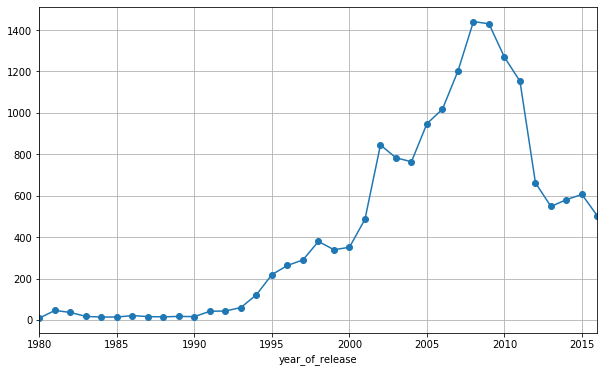

In [14]:
graf = df.groupby('year_of_release')['name'].count()
graf.plot(x='year_of_release', y='name', style='o-', grid=True);

До 1994 года количество выпускаемых игр не превышало 30-50 в год. После 1994 года начался всплеск интереса к видео-играм и резкий рост их количества в год. Пик пришелся на 2008-2009 годы, когда в год выпускалось более чем по 1400 новых игр. Затем последовало резкое снижение и к 2013 году их количество сократилось в двое. Для анализа наиболее интересен период с момента, когда началсы рост и по настоящий момент(год предоставления данных - 2016). 

In [15]:
df_1994 = df.query('year_of_release > 1994')
#df_1994

Далее проанализируем как менялись продажи по платформам со временем.

In [16]:
df_platform = df_1994.groupby('platform')['total_sale'].sum().sort_values(ascending = False).reset_index()
df_platform.T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
platform,PS2,X360,PS3,Wii,DS,PS,PS4,GBA,PSP,3DS,...,WiiU,PSV,SNES,SAT,DC,WS,NG,TG16,3DO,PCFX
total_sale,1247.16,966.61,934.71,903.31,804.26,721.55,314.14,313.73,293.57,258.53,...,82.19,53.81,49.59,29.94,15.95,1.42,0.43,0.16,0.08,0.03


In [17]:
#отсортируем платформы: оставим те, где суммарные продажи составили более 150 млн. 
df_platform = df_platform.query('total_sale > 150.000000')
df_platform = df_platform['platform']

In [18]:
#создадим таблицу в которую входят только платформы из списка и посмотрим результат
pl_year = df_1994.query('platform in @df_platform')
pl_year.groupby('platform')['year_of_release'].count().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
platform,3DS,DS,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,Wii,X360,XB,XOne
year_of_release,515,2128,813,552,318,957,1173,2140,1319,392,1203,1301,1250,817,247


In [19]:
pl_year.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77


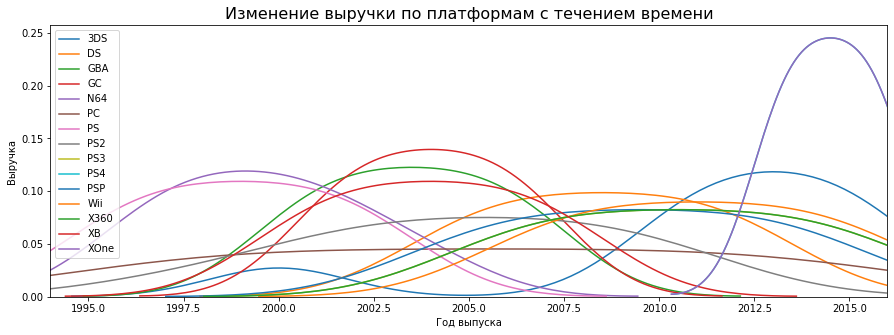

In [20]:
#сгруппируем предыдущую таблицу по платформе и году и посчитаем суммарные продажи
gr_pl_year = (pl_year.pivot_table(index=['platform','year_of_release'],
                                  values=['total_sale'],
                                  aggfunc=['sum']).reset_index())
#изменим названия столбцов после группировки
gr_pl_year.columns = ['platform','year_of_release','total_sale']

#построим график выручки по платформам по годам
fig, ax = plt.subplots(figsize=(15,5))
for platform in gr_pl_year['platform'].unique():
    sns.kdeplot(gr_pl_year[gr_pl_year['platform'] == platform]['year_of_release'], 
                label = platform)
plt.xlim(1994,2016)
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.title('Изменение выручки по платформам с течением времени', fontsize=16)
plt.show()

In [21]:
gr_pl_year.head(20)

,platform,year_of_release,total_sale
0,3DS,2000,0.02
1,3DS,2010,0.30
2,3DS,2011,63.20
3,3DS,2012,51.76
4,3DS,2013,56.57
5,3DS,2014,43.76
6,3DS,2015,27.78
7,3DS,2016,15.14
8,DS,2004,17.27
9,DS,2005,130.14


По графику можно сделать вывод, что у большинства платформ есть свой жизненный цикл, свойственный любому продукту - появление, рост, максимум, спад, уход с рынка. Редкие платформы переживают повторный подъем после спада, это скорее всего связано с приходом на рынок новых технологий.
В 1995-х и в 2000-х годах платформы появлялись группами и дублировали свои жизненные циклы. Очевидно, что это были конкуренты.
А жизненный цикл составляет примерно 10 лет. 

Для построения прогноза на будущее возьмем чуть меньший временной период, чтобы яснее понимать тенденцию. Пусть это будет 7 лет.

In [22]:
df_7year = df.query('2010 <= year_of_release <= 2016')

In [23]:
df_7years_pl = df_7year.groupby('platform')['total_sale'].sum().sort_values(ascending = False).reset_index()
df_7years_pl.T

,0,1,2,3,4,5,6,7,8,9,10,11
platform,PS3,X360,PS4,3DS,Wii,XOne,DS,PC,WiiU,PSP,PSV,PS2
total_sale,590.65,553.3,314.14,258.51,225.06,159.32,124.89,124.82,82.19,64.55,53.81,6.09


Возьмем 7 самых прибыльных платформ:

In [24]:
#отсортируем платформы: оставим те, где суммарные продажи составили более 150 млн. 
df_7years_pl = df_7years_pl.query('total_sale > 150.000000')
df_7years_pl = df_7years_pl['platform']

#создадим таблицу в которую входят только платформы из списка
pl_year_7 = df_7year.query('platform in @df_7years_pl')

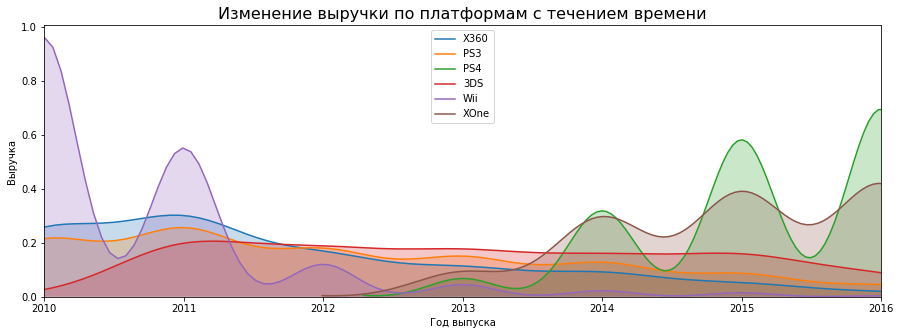

In [25]:
#построим график выручки по платформам по годам
fig, ax = plt.subplots(figsize=(15,5))
for platform in pl_year_7['platform'].unique():
    sns.kdeplot(pl_year_7[pl_year_7['platform'] == platform]['year_of_release'], 
                label = platform, shade=True)
plt.xlim(2010,2016)
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.title('Изменение выручки по платформам с течением времени', fontsize=16)
plt.show()


Видим, что лидером к 2016 году является PS4, продажи по ней продолжают расти. На втором месте XOne, также с тенденций к росту. Характерно, что появились они примерно одновременно, в середине 2012 года.

Wii на стадии выхода с рынка уже с середины 2013 года.

Остальные платформы не имеют выраженных скачков в этом временном интервале, они приносили стабильную прибыль на протяжении выбранного периода времени с тенденцией к постепенному снижению продаж. Можно сделать прогноз, что в 2017 продажи также будут постепенно убывать.

Таким образом, лидерами в 2017 году станут PS4 и XOne.

Построим диаграммы размаха по глобальным продажам в разбивке по платформам.

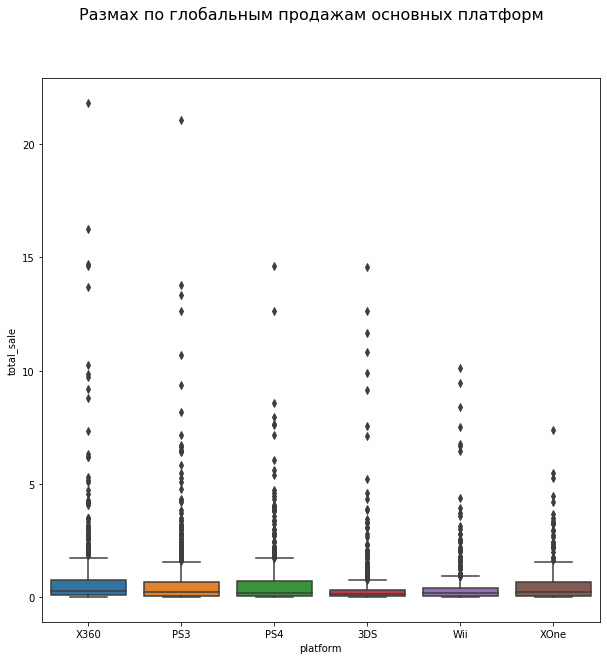

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="platform", y="total_sale", data=pl_year_7);
fig.suptitle('Размах по глобальным продажам основных платформ', fontsize=16)
plt.show()

Видно, что большая часть выручки лежит в диапазоне до 1 млн. c выбросами, некоторые из которых свыше 20 млн. Но при этом первый квартиль по каждой платфоре лежит ближе к нулю. Видим, что по всем платформам имеем длинный верхний ус, а выше него большое количество выбросов. Продажи по платформам X360, PS3, PS4 и XOne почти не различаются.

Посмотрим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. PS4 и XOne являются лидерами в последние годы, поэтому сделаем выборку и анализ именно по этим платформам. Построим графики и посчитаем корреляцию между отзывами и продажами.

In [27]:
#при выборке учтем, что в critic_score и user_score заполняли пропуски, удалим эти строки
def diagramma(plat):    
    df_7year_PS4 = df_7year[df_7year['platform']==plat].query('user_score!= 5000 & critic_score !=5000')
    fig, ax = plt.subplots(figsize=(7,7))
    sns.kdeplot(df_7year_PS4['user_score'], df_7year_PS4['total_sale'], 
            color='r', shade=True, cmap="Reds", shade_lowest=False);
    sns.kdeplot(df_7year_PS4['critic_score'], df_7year_PS4['total_sale'], 
            color='b', shade=True, cmap="Blues", shade_lowest=False);
    plt.ylim(-1,6)
    plt.title('Корреляция оценок пользователей(red) и критиков(blue) с продажами', fontsize=12)
    
    print('Корреляция продаж', plat, 'и оценок пользователей:\t', df_7year_PS4['user_score'].corr(df_7year_PS4['total_sale']).round(2))
    print('Корреляция продаж', plat, 'и оценок критиков:     \t',df_7year_PS4['critic_score'].corr(df_7year_PS4['total_sale']).round(2))

Корреляция продаж PS4 и оценок пользователей:	 -0.03
Корреляция продаж PS4 и оценок критиков:     	 0.41


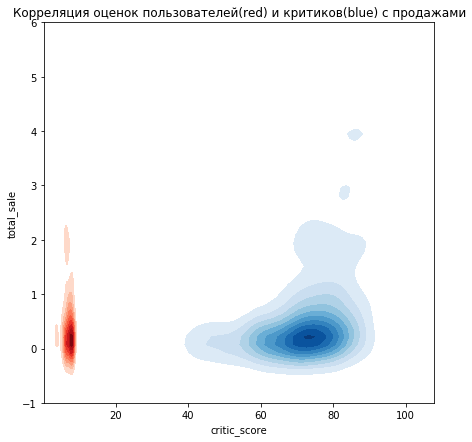

In [28]:
diagramma('PS4')

Корреляция продаж XOne и оценок пользователей:	 -0.09
Корреляция продаж XOne и оценок критиков:     	 0.41


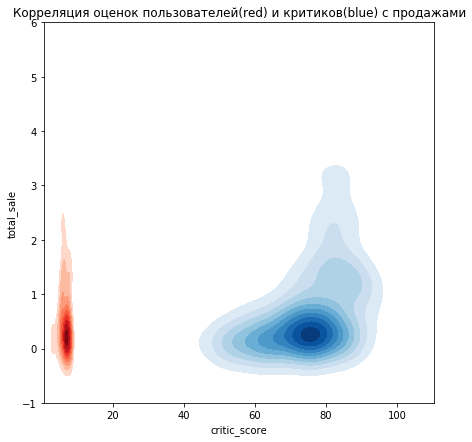

In [29]:
diagramma('XOne')

Видим, что корреляция между оценками пользователей и продажами близка к нулю, а значит связи почти нет, т.е. продажи слабо зависят от оценок пользователей и на этот критерий нельзя полагаться. И напротив, почти линейная связь между оценками критиков и продажами, где критики выставили более высокие оценки, там и продажи выше.

Посмотрим на общее распределение игр по жанрам, чтобы узать какие из них самые прибыльные.

In [30]:
df_7year_gen = df_7year.groupby('genre')['total_sale'].sum().sort_values(ascending = False).reset_index()
df_7year_gen

,genre,total_sale
0,Action,680.68
1,Shooter,482.22
2,Sports,329.43
3,Role-Playing,315.33
4,Misc,235.05
5,Racing,122.68
6,Platform,119.72
7,Fighting,81.59
8,Simulation,72.05
9,Adventure,61.00


Из полученной таблицы можно сделать необходимые выводы, однако визуализируем ее для большей наглядности:

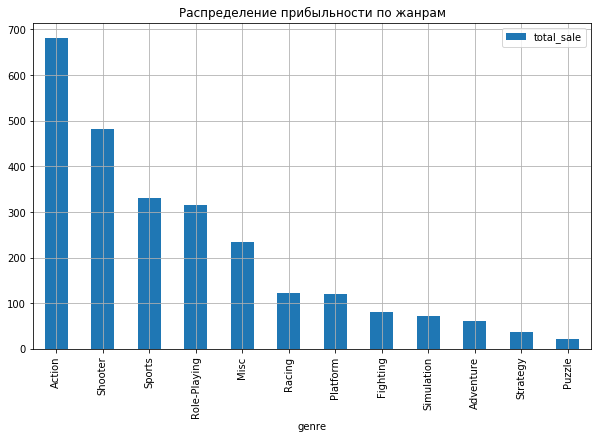

In [31]:
df_7year_gen.plot.bar(x='genre', y='total_sale', 
                      grid=True, title='Распределение прибыльности по жанрам');

Самый прибыльный жанр за последние 7 лет- Action, он но 40 процентов более прибылен чем его ближайший конкурент, серебрянный призер Shooter. На третьем и четвертом месте по выручке находятся Sports Role-Playing, с незначительным отличаем. Из этого делаем вывод, что все что связано с движением, активностью и снятием стресса лидирует по продажам. Жанр Misc также не сильно отстает, это связано с его высокой распространенностью, ведь музыка сопровождает нас повсеместно. Оставшиеся жанры больше связаны с интеллектом и продаюся не так хорошо и даже все в сумме не дают такой выручки как лидер списка, однако тоже представляют интерес и находят своего покупателя.

## 4. Портрет пользователя каждого региона. <a id='#step4'></a>

Составим портреты игроков в каждом регионе и посмотрим есть ли различия в продажах. Для этого выделим Топ-5 платформ в каждом регионе.

In [32]:
def portret(region,reg):
    df_reg = df_7year.groupby('platform')[region].sum().sort_values(ascending = False).reset_index().head()
    df_reg.plot.bar(x='platform', y=region, figsize=(4,3),
                    grid=True, title=reg);

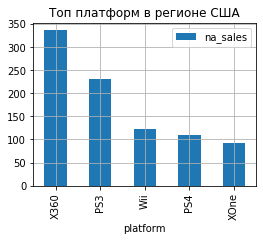

In [33]:
portret('na_sales', 'Топ платформ в регионе США')

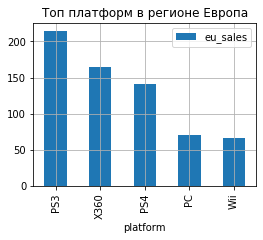

In [34]:
portret('eu_sales', 'Топ платформ в регионе Европа')

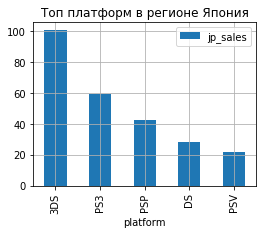

In [35]:
portret('jp_sales', 'Топ платформ в регионе Япония')

Первое, что бросается в глаза, то что в Америке игр продается больше, чем в Европе и Японии.
Что касается предпочтений по платформам, то Европе и в Америке вкусы геймеров очень близки. Топ-5 здесь почти совпадает, а первые два места занимают одинаковые игры, хотя с разницей в объеме продаж. А вот азиатский регион сильно отличается по игровым предпочтениям. Здесь только одна платформа из популяных в Америке и Европе смолга попасть в Топ-5  - это PS3 и заняла почетное второе место. Остальные игры здесь отличаются. Думаю это говорит также и о различии менталитетов.

## 5. Проверка гипотез. <a id='#step5'></a>

Сначала напишем функцию проверки гипотез:

In [36]:
#очистим данные от искусвенно заполненных значений
df_mean = df_7year.query('user_score !=5000.0 & critic_score !=5000.0')

In [37]:
#функция проверки гипотез
def correlation(table, col1, val1, val2):
    table1 = table[table[col1] == val1]['user_score']
    table2 = table[table[col1] == val2]['user_score']
    alpha = 0.05
    results = st.ttest_ind(table1, table2)    
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

#### 5.1 Гипотеза:
- Нулевая гипотеза: Средние пользовательские рейтинги платформ XOne и PC одинаковые
- Альтернативная гипотеза: Средние пользовательские рейтинги платформ XOne и PC различаются

In [38]:
correlation(df_mean, 'platform', 'XOne', 'PC')

p-значение: 0.983488649278083
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, это означает, что средние пользовательские рейтинги платформ XOne и PC одинаковые.

#### 5.2 Гипотеза:
- Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые
- Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные

In [39]:
correlation(df_mean, 'genre', 'Action', 'Sports')

p-значение: 5.4343139442135733e-11
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, а значит средние пользовательские рейтинги жанров Action и Sports разные.

Были проверены две гипотезы и получен результат. Однако, на мой взгляд, данные выводы могут быть ошибочны, поскольку выборка изначальных корректных данных по стобцу пользовательского рейтинга слишком мала, особенно при отборе значений по конкретной платформе или жанру.

## 6. Окончательные выводы. <a id='#step6'></a>

Итак, мы увидели что:

1) Игровая индустрия менялась с течением времени. До 1994 года появлялось не более 50 новых игр в год, кратный рост их количества начался с 1994-1995 г и достиг пика к 2008-2009 годам. Затем количство выпускаемых игр снова пошло на спад. Возможно это связано с тем, что производители стали делать больше акцент на качество, графику и лучше понимать потребности геймеров, появилась некоторая статистика, на основе которой могли создаваться новые продукты более осмысленно. Также, возможно, это связано просто с изменением технологий, пресыщением рынка и с тем, что сегодня это по большей части не отдельные игровые приставки, а по сути компьютереные программы.

2) Отследили жизненный цикл игровых платформ, оно оказался равным приблизительно 10 годам и имеет характерные для любого продукта с точки зрения маркетинга стадии жизненного цикла. В 1995-х и в 2000-х годах платформы появлялись группами и тесно конкурировали между собой. За последние 7 лет самыми прибыльными были платформы PS3, X360 и PS4, а в следующем (2017) году лидерами продаж станут PS4 и XOne.

3) При оценке продаж не стоит полагаться на отзывы пользователей, это обманчивый критерий. А вот оценки критиков напротив стоит учитывать, поскольку их корреляция с продажами почти линейная.

4) Самыми прибыльными жанрами за последние 7 лет стали Action, Shooter и Sports, поделив три первых места в рейтинге. При этом жанр Action лидирует с большим отрывом. Также, в целом заметно, что пользователям больше по душе игры связанные с подвижностью и снятием стресса, чем интеллектуальные.

5) Предпочтения геймеров также различаются и по регионам. При этом американский и европейский рынки ближе друг к другу, в то время как азиатский имеет свою специфику и видимо требует особого подхода при создании новых игр с учетом менталитета, там не работают в явном виде правила американо-европейского рынка. Платформа PS3 в этом отношении самая универсальная, завоевавшая популярность во всех регионах.

6) В результате проверки гипотез выявлены закономерности: "средние пользовательские рейтинги платформ XOne и PC одинаковые" и "средние пользовательские рейтинги жанров Action и Sports разные". Однако, на мой взгляд, для большей уверенности в этом необходимы более полные исходные данные.


Думаю, на данный момент, производители больше сконцентрированы на улучшении качества имеющихся игр, улучшения существующего кода, для более быстрой работы при улучшенной графике и поисках новых технологий. Также легко предположить, что для серьезного качественного скачка в индустрии нужны новые технологии, увеличение вычислительной мощности компьютеров и с появлением в широком доступе квантовых компьютеров игровая индустрия будет переживать новый всплеск, как и другие сферы нашей жизни.